<a href="https://colab.research.google.com/github/jeffkblee/Image-Processing/blob/main/Jeffrey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/DODAS-TS/boto3sts
!pip install 'https://github.com/CYGNUS-RD/middleware/blob/master/midas/midaslib.tar.gz?raw=true'
!pip install git+https://github.com/CYGNUS-RD/cygno.git -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DODAS-TS/boto3sts to /tmp/pip-req-build-3oicl0mq
  Running command git clone -q https://github.com/DODAS-TS/boto3sts /tmp/pip-req-build-3oicl0mq
     |████████████████████████████████| 132 kB 5.1 MB/s 
     |████████████████████████████████| 8.9 MB 40.2 MB/s 
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 138 kB 41.5 MB/s 
     |████████████████████████████████| 856 kB 18.1 MB/s 
     |████████████████████████████████| 127 kB 44.6 MB/s 
  Created wheel for boto3sts: filename=boto3sts-0.0.8-py3-none-any.whl size=4677 sha256=b43b9e431d80218db3572f9a1d039e98e7d0541b1f575110ab72a9cf71a2b4df
  Stored in directory: /tmp/pip-ephem-wheel-cache-uq4azkre/wheels/d6/0e/a8/204df23fe4a288550d10cf9cf744ab143484e177e12982e424
Successfully built boto3sts
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.

100.0% 731365376 / 731359053


Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 1 contains banks CAM0
Event # 1 of type ID 1 contains banks CAM0
Event # 2 of type ID 1 contains banks CAM0
Event # 3 of type ID 1 contains banks CAM0
Event # 4 of type ID 1 contains banks CAM0
Event # 5 of type ID 1 contains banks CAM0
Event # 6 of type ID 1 contains banks CAM0
Event # 7 of type ID 1 contains banks CAM0
Event # 8 of type ID 1 contains banks CAM0
Event # 9 of type ID 1 contains banks CAM0
Event # 10 of type ID 1 contains banks CAM0
Event # 11 of type ID 1 contains banks CAM0
Event # 12 of type ID 1 contains banks CAM0
Event # 13 of type ID 1 contains banks CAM0
Event # 14 of type ID 1 contains banks CAM0
Event # 15 of type ID 1 contains banks CAM0
Event # 16 of type ID 1 contains banks CAM0
Event # 17 of type ID 1 contains banks CAM0
Event # 18 of type ID 1 contains banks CAM0
Event # 19 of type ID 1 contains banks C

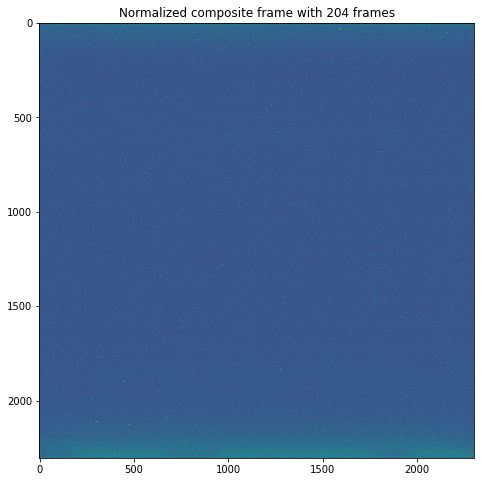

In [2]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy


# Reads pedestal images from an array and combines them.
# Generate a normalized composite image.
# Input: run number, path
# Output: normalized mean image, std of images, number of frames used to generate said image.
# Note: Needs manual checking of shape of array to set up "image" variable.
def ped_array(run, path = '/tmp/', cloud = True, tag = 'STD', verbose = True):

    mfile = cy.open_mid(run=run, path=path, cloud=cloud, tag=tag, verbose=verbose)
    foutm_name = (path+"mean_Run{:05d}".format(run)+"ped")
    fouts_name = (path+"sigma_Run{:05d}".format(run)+"ped")
    
    noFrame = 0
    #shape of the images array (23004,2304)
    m_image = np.zeros((2304,2304)) # average value of frames
    s_image = np.zeros((2304,2304)) # root mean square of frames
    for event in mfile:
        if event.header.is_midas_internal_event():
            if verbose: print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
        print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
        if verbose: print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
        if verbose: print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

        #if noFrame >= 3: break # Limit the frames produced for ease of debugging
        for bank_name, bank in event.banks.items():
            if bank_name=='DGH0': # PMTs wavform 
                header = cy.daq_dgz2header(bank)
                print (header)
                waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
            if bank_name=='CAM0': # CAM image
                imageFrame, _, _ = cy.daq_cam2array(bank)
                m_image = np.add(m_image, imageFrame)
                s_image = np.add(s_image, imageFrame**2)
                # plt.figure(figsize=(8,8))
                # plt.imshow(imageFrame, vmin=95, vmax=115)
                # plt.title("Frame %s" %noFrame)
                # plt.show()
                noFrame += 1
            if bank_name=='INPT': # SLOW channels array
                slow = cy.daq_slow2array(bank)

    m_image = m_image/noFrame
    np.save(foutm_name, m_image)

    s_image = np.sqrt((s_image - m_image**2 * noFrame)/(noFrame - 1))
    np.save(fouts_name, s_image)
    # print(s_image)


    # plt.figure(figsize=(8,8))
    # plt.imshow(s_image, vmin=0, vmax=10)
    # plt.title("Normalized RMS frame with %s frames" %noFrame)
    # plt.show()

    return m_image, s_image, noFrame



# Run 250 Pedestal at LNF
pedestal_mean, pedestal_sigma, noFrame = ped_array(250, verbose = False)
plt.figure(figsize=(8,8))
plt.imshow(pedestal_mean, vmin=95, vmax=115)
#plt.imshow(pedestal_sigma, vmin=0, vmax=10)
plt.title("Normalized composite frame with %s frames" %noFrame)
plt.show()

100.0% 783933440 / 783929299


Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Event # 0 of type ID 1 contains banks CAM0
Event # 1 of type ID 1 contains banks CAM0
Event # 2 of type ID 1 contains banks CAM0
Event # 3 of type ID 1 contains banks CAM0
Event # 4 of type ID 1 contains banks CAM0
Event # 5 of type ID 1 contains banks CAM0
Event # 6 of type ID 1 contains banks CAM0
Event # 7 of type ID 1 contains banks CAM0
Event # 8 of type ID 1 contains banks CAM0
Event # 9 of type ID 1 contains banks CAM0
Event # 10 of type ID 1 contains banks CAM0
Event # 11 of type ID 1 contains banks CAM0
Event # 12 of type ID 1 contains banks CAM0
Event # 13 of type ID 1 contains banks CAM0
Event # 14 of type ID 1 contains banks CAM0
Event # 15 of type ID 1 contains banks CAM0
Event # 16 of type ID 1 contains banks CAM0
Event # 17 of type ID 1 contains banks CAM0
Event # 18 of type ID 1 contains ba

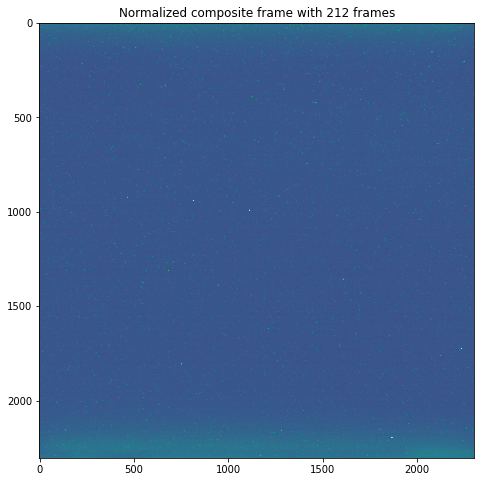

In [3]:
#Run 1403 Pedestal LNGS
pedestal_mean, pedestal_sigma, noFrame = ped_array(1403, verbose = False)
plt.figure(figsize=(8,8))
plt.imshow(pedestal_mean, vmin=95, vmax=115)
#plt.imshow(pedestal_sigma, vmin=0, vmax=10)
plt.title("Normalized composite frame with %s frames" %noFrame)
plt.show()

In [ ]:

import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy

# Reads images from an array and subtracts the pedestal.
# Input: run number, path
# Output: images minus pedestal
# Note: Needs manual insertion of path for pedestal
def ima_array(run, ped_run, verbose = True):

    mfile = cy.open_mid(run=run, path='/tmp/', cloud=True, tag='STD', verbose=verbose)

    ped = np.load("/tmp/mean_Run{:05d}".format(ped_run)+"ped.npy")#("/tmp/mean_Run00250ped.npy") #Input pedestal associated with run.
    noFrame = 0
    #shape of the images array (23004,2304)
    image = np.zeros((2304,2304)) # average value of frames
    for event in mfile:
        if event.header.is_midas_internal_event():
            if verbose: print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
        print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
        if verbose: print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
        if verbose: print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

        #if noFrame >= 10: break # Limit the frames produced for ease of debugging
        for bank_name, bank in event.banks.items():
            if bank_name=='DGH0': # PMTs wavform 
                header = cy.daq_dgz2header(bank)
                print (header)
                waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
            if bank_name=='CAM0': # CAM image
                #if noFrame >= 10: break
                image, _, _ = cy.daq_cam2array(bank)
                image = np.subtract(image, ped)
                # plt.figure(figsize=(8,8))
                # plt.imshow(image, vmin=0, vmax=20)
                # plt.title("Frame %s" %noFrame)
                # plt.show()
                # print(image)

                foutname = "/tmp/Run%s_Images/Frame%s" % (run,noFrame)
                np.save(foutname, image)
                
                noFrame += 1
            if bank_name=='INPT': # SLOW channels array
                slow = cy.daq_slow2array(bank)


    # print(s_image)


    # plt.figure(figsize=(8,8))
    # plt.imshow(s_image, vmin=0, vmax=10)
    # plt.title("Normalized RMS frame with %s frames" %noFrame)
    # plt.show()

    return 0


# Run 1402 Image LNGS
ima_array(1402,1403, verbose = False)

Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Event # 0 of type ID 1 contains banks CAM0
Event # 1 of type ID 1 contains banks CAM0
Event # 2 of type ID 1 contains banks CAM0
Event # 3 of type ID 1 contains banks CAM0
Event # 4 of type ID 1 contains banks CAM0
Event # 5 of type ID 1 contains banks CAM0
Event # 6 of type ID 1 contains banks CAM0
Event # 7 of type ID 1 contains banks CAM0
Event # 8 of type ID 1 contains banks CAM0
Event # 9 of type ID 1 contains banks CAM0
Event # 10 of type ID 1 contains banks CAM0
Event # 11 of type ID 1 contains banks CAM0
Event # 12 of type ID 1 contains banks CAM0
Event # 13 of type ID 1 contains banks CAM0
Event # 14 of type ID 1 contains banks CAM0
Event # 15 of type ID 1 contains banks CAM0
Event # 16 of type ID 1 contains banks CAM0
Event # 17 of type ID 1 contains banks CAM0
Event # 18 of type ID 1 contains ba

0

In [ ]:
# Run 249 Image LNF
ima_array(249, 250, verbose = False)

Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 1 contains banks CAM0
Event # 1 of type ID 1 contains banks CAM0
Event # 2 of type ID 1 contains banks CAM0
Event # 3 of type ID 1 contains banks CAM0
Event # 4 of type ID 1 contains banks CAM0
Event # 5 of type ID 1 contains banks CAM0
Event # 6 of type ID 1 contains banks CAM0
Event # 7 of type ID 1 contains banks CAM0
Event # 8 of type ID 1 contains banks CAM0
Event # 9 of type ID 1 contains banks CAM0
Event # 10 of type ID 1 contains banks CAM0
Event # 11 of type ID 1 contains banks CAM0
Event # 12 of type ID 1 contains banks CAM0
Event # 13 of type ID 1 contains banks CAM0
Event # 14 of type ID 1 contains banks CAM0
Event # 15 of type ID 1 contains banks CAM0
Event # 16 of type ID 1 contains banks CAM0
Event # 17 of type ID 1 contains banks CAM0
Event # 18 of type ID 1 contains banks CAM0
Event # 19 of type ID 1 contains banks C

0